> ### 필요 패키지 및 폰트 설치

In [1]:
# !pip install konlpy
# !pip install wordcloud

# !pip install pyLDAvis

# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

> ### 패키지 불러오기

In [2]:
import re
from datetime import datetime
from time import time
import collections

import requests, json
from bs4 import BeautifulSoup
import urllib.parse as parse

from tqdm import tqdm
import pickle
from pprint import pprint as print

import numpy as np
import pandas as pd
import sklearn as sk

from konlpy.tag import Okt, Komoran # komoran, hannanum, kkma, mecab
import gensim
from gensim.summarization import summarize

# visualization
import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams
import seaborn as sns
from wordcloud import WordCloud
import pyLDAvis.gensim_models

# 브라우저에서 바로 그려지도록 
# %matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# # Colab 의 한글 폰트 설정
# plt.rc('font', family='NanumSquareRound') 

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

# Seaborn 테마 설정
sns.set_theme(style="ticks", color_codes=True, font='NanumSquareRound', font_scale=2)

# 워닝 메세지 삭제
import warnings
warnings.filterwarnings(action='ignore')

# font_list = [font.name for font in fm.fontManager.ttflist]
# font_list

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


> ### 폰트 선택

In [3]:
font_list = [font.name for font in fm.fontManager.ttflist]
font_list
font_path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'

In [4]:
# 피클 사용법
# list = ['a', 'b', 'c']
# with open('list.txt', 'wb') as f:
#   pickle.dump(list, f)

# with open('list.txt', 'rb') as f:
#   data = pickle.load(f)

> ### 전처리

In [5]:
df = pd.read_csv('러시아 한국 경제_v2_2022041520220224.csv')

In [6]:
def clean_content(content):
  stripped = content[69:-2]
  cleaned = re.sub('[^가-힣ㄱ-ㅣa-zA-Z|0-9.%]', ' ', string=stripped)
  return cleaned

def clean_title(title):
  cleaned = re.sub('[^가-힣ㄱ-ㅣa-zA-Z|0-9.%]', ' ', string=title)
  return cleaned

In [7]:
df['내용'] = df['내용'].apply(clean_content)
df['제목'] = df['제목'].apply(clean_title) + '.'
df['제목내용'] = df['제목'] + ' ' + df['내용']

> ### 사용자 사전 추가 & 토큰화



In [8]:
# kmr = Komoran(userdic='user_dictionary.txt')
kmr = Komoran()

In [9]:
preprocessed = df['제목내용'].apply(kmr.nouns)

> ### 불용어 삭제

In [10]:
with open('stopwords.pickle', 'rb') as f:
  stopwords = pickle.load(f)
with open('news_lst.pickle', 'rb') as f:
  news_lst = pickle.load(f)

more_sw = [
           '정은',
           '정부',
           '일보',
           '유사점',
           '소우',
           '권위',
           '인텔리전스',
           '피켓',
           '회장',
           '결',
           '김화영',
           '벡스',
           '유승준',
           '최경영',
           '현수',
           '소프',
           '경식',
           '입찰'
           '다운로드',
           '스토어',
           '유닛',
           '극동방송',
           '석관',
           '스트리트',
           'WP',
           '평론가',
           '320',
           '승관',
]
stopwords.extend(news_lst)
# stopwords.extend(more_sw)

In [11]:
# 불용어 삭제 함수
# 한글자 단어도 삭제

def sw_rmv(row):
  lst = []
  for el in row:
    if el not in stopwords: # and len(el) > 1:
      lst.append(el)
  return lst

In [12]:
preprocessed = preprocessed.apply(sw_rmv)

> ### 트라이그램화

In [13]:
def to_trigrams(row):
  bigram = gensim.models.Phrases(row, delimiter=b' ')
  trigram = gensim.models.Phrases(bigram[row], delimiter=b' ')  
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  trigram_mod = gensim.models.phrases.Phraser(trigram)
  new_row = bigram_mod[row]
  new_row = trigram_mod[bigram_mod[row]]
  
  return new_row

In [14]:
preprocessed = preprocessed.apply(to_trigrams)

> ### TF*IDF 구축

In [15]:
dictionary = gensim.corpora.Dictionary(preprocessed) # 토큰별 아이디 부여

In [16]:
corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in preprocessed] # BoW Corpus 생성

In [17]:
tfidf = gensim.models.TfidfModel(corpus, smartirs='ntc') # TF*IDF 생성

> ### LDA 토픽 모델링 최적 파라미터 찾기

> #### coherence(높을 수록 굿)와 perplexity(낮은 게 굿)를 보면서 fine tuning 가능

In [18]:
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [19]:
font_path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'

In [20]:
# # 응집도와 복잡도 출력

# from gensim.models.coherencemodel import CoherenceModel

# cm = CoherenceModel(model=lda_model, corpus=tfidf[corpus], coherence='u_mass')
# coherence = cm.get_coherence()
# perplexity = lda_model.log_perplexity(tfidf[corpus])
# print(coherence)
# print(perplexity)

> #### 최적 에폭(passes)와 토픽 갯수 찾기

In [21]:
# # to find optinal passes(epochs)

# from gensim.models.coherencemodel import CoherenceModel

# num_topics = 4
# chunksize = 2000
# # passes = 20
# iterations = 400
# eval_every = None
# random_state = 100

# coherences=[]
# perplexities=[]
# passes_lst=[]

# for i in range(10):
#     if i==0:
#         passes=1
#     else:
#         passes=i*5
#     tic = time()
#     lda_model = gensim.models.ldamodel.LdaModel(corpus=tfidf[corpus],
#                                                 id2word=dictionary,
#                                                 num_topics=num_topics,
#                                                 chunksize=chunksize,
#                                                 passes=passes,
#                                                 iterations=iterations,
#                                                 random_state=random_state,
#                                                 eval_every=eval_every,)
#     print(f'epoch: {passes} {time()}')

#     cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
#     coherence = cm.get_coherence()
#     perplexity = lda_model.log_perplexity(corpus)
#     coherences.append(coherence)
#     perplexities.append(perplexity)
#     print(f'Coherence: {coherence}')
#     print(f'Perplexity: {perplexity}')

In [22]:
# 트라이그램 사용자 사전 안 쓰고 불용어는 신문사명 107개랑 324개 기초만
# 'epoch: 40 1650354702.8733625'
# 'Coherence: -7.95634932266013'
# 'Perplexity: -8.229182282166434'

In [23]:
# # to find optimal num_topics

# coherencesT = []
# perplexitiesT = []
# passes = 15

# for i in range(1, 11):
#     num_topics = i * 2
#     tic = time()
#     lda_models = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num_topics, iterations=400, passes=passes)
#     print(f'num_topics: {num_topics} {time()}')

#     cm = CoherenceModel(model=lda_models, corpus=corpus, coherence='u_mass')
#     coherence = cm.get_coherence()
#     perplexity = lda_models.log_perplexity(corpus)
#     coherencesT.append(coherence)
#     perplexitiesT.append(perplexity)
#     print(f'coherence: {coherence}')
#     print(f'perplexity: {perplexity}')

In [24]:
# 'num_topics: 4 1650341409.307819'
# 'coherence: -0.7880039420247344'
# 'perplexity: -7.44461009050456'

> ### LDA 토픽 모델링

> #### random_state 고정 후 사용자 사전 및 불용어 사전 업데이트 필수

In [25]:
num_topics = 4 # 토픽 수 설정
chunksize = 2000 # 한번에 처리할 row 수 설정
passes = 40 # 에폭 Number of passes through the corpus during training.
iterations = 400 # Maximum number of iterations through the corpus when inferring the topic distribution of a corpus.
eval_every = None # log 복잡도 계산 수행 유무 설정 1로 설정하면 학습이 2배로 느려짐
random_state = 100 # 재실행 시 같은 결과를 같기 위해 난수 설정

lda_model = gensim.models.ldamodel.LdaModel(corpus=tfidf[corpus],
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            chunksize=chunksize,
                                            passes=passes,
                                            iterations=iterations,
                                            random_state=random_state,
                                            eval_every=eval_every,)

In [26]:
print(lda_model.print_topics())

[(0,
  '0.001*"첼시" + 0.000*"컨소시엄" + 0.000*"입찰" + 0.000*"스포츠" + 0.000*"캔디" + '
  '0.000*"구단주" + 0.000*"구단" + 0.000*"프리미어리그" + 0.000*"FC" + 0.000*"특허"'),
 (1,
  '0.004*"곡물" + 0.003*"칼국수" + 0.003*"밀가루" + 0.003*"사료" + 0.002*"분기" + '
  '0.002*"식용" + 0.002*"냉면" + 0.002*"가격" + 0.002*"한국농촌경제연구원" + 0.002*"선물"'),
 (2,
  '0.003*"물가" + 0.003*"금리" + 0.002*"유가" + 0.002*"상승" + 0.002*"가격" + 0.002*"인상" '
  '+ 0.002*"제재" + 0.001*"수출" + 0.001*"기업" + 0.001*"수입"'),
 (3,
  '0.001*"헤리티지 재단" + 0.001*"도넛" + 0.000*"로버츠" + 0.000*"케빈" + 0.000*"직항" + '
  '0.000*"아이스크림" + 0.000*"롯데제과" + 0.000*"던킨" + 0.000*"빼빼로" + 0.000*"크리스"')]


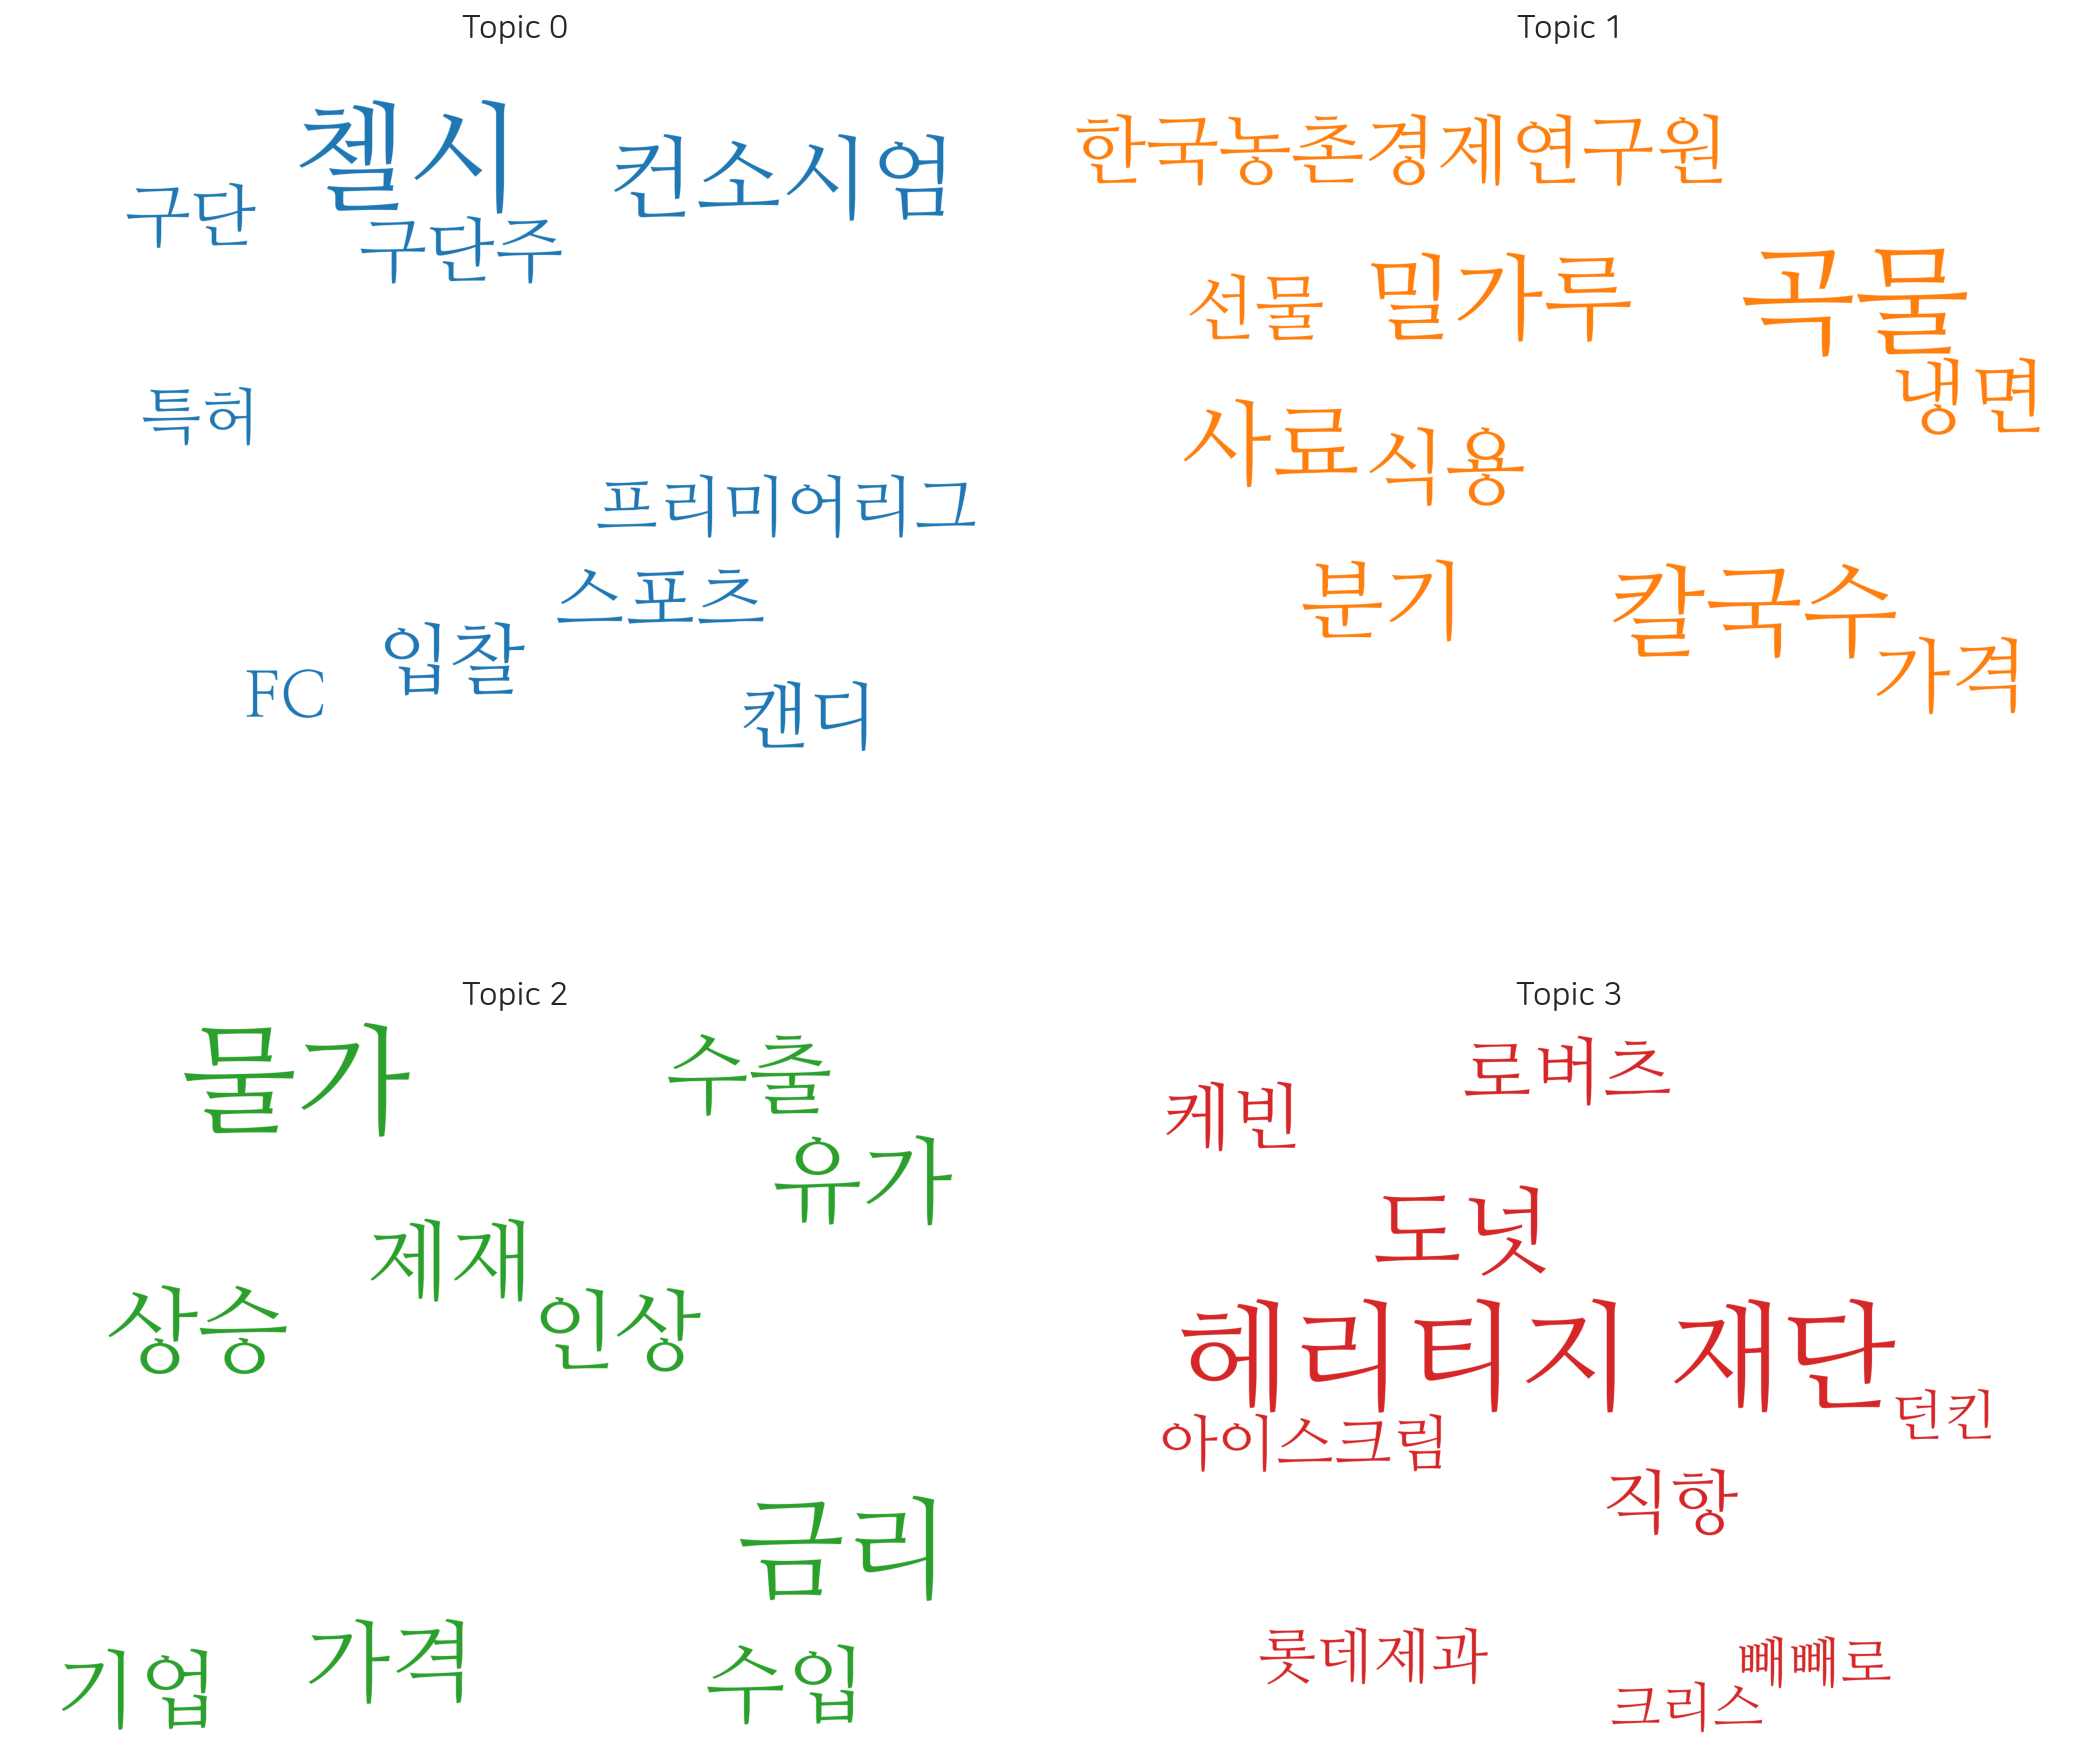

In [27]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0,
                  font_path=font_path)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [28]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, tfidf[corpus], dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.113027  0.000141       1        1  90.132260
1      0.036694 -0.014454       2        1   4.848251
0      0.038253  0.007227       3        1   2.531605
3      0.038080  0.007086       4        1   2.487884, topic_info=     Term       Freq      Total Category  logprob  loglift
6      곡물  16.000000  16.000000  Default  30.0000  30.0000
1      가격  21.000000  21.000000  Default  29.0000  29.0000
129    분기  14.000000  14.000000  Default  28.0000  28.0000
132    사료   5.000000   5.000000  Default  27.0000  27.0000
50     서울   9.000000   9.000000  Default  26.0000  26.0000
...   ...        ...        ...      ...      ...      ...
9725  나뚜루   0.035206   0.275517   Topic4  -9.2147   1.6363
9970   편식   0.037463   0.299771   Topic4  -9.1526   1.6141
2119  전문점   0.048279   0.431894   Topic4  -8.8990   1.5026
8513  크리스   0.063158   0.795509   Topic4  -8.6303   1.1604
2790   피크   0.053442   0.947407   Topic4  -8.7974   0.8186

[189 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1039      1  0.969330     .co
1040      1  0.915389     .kr
1         1  0.919683      가격
1         2  0.045984      가격
4         1  0.761746     거래소
...     ...       ...     ...
101       2  1.261734  한국소비자원
102       1  0.607550      해상
102       2  0.607550      해상
103       1  0.941023      해외
1255      1  1.008523      후보

[106 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

> ### 토큰화 체크

In [29]:
kmr.nouns('김재연')

['김재연']

> ### user_dicttionary.txt

In [31]:
# 우크라사태
# 우크라

# 젤렌스키
# 볼로디미르 젤렌스키
# 데니소바
# 류드밀라 데니소바
# 커비
# 존 커비
# 로버츠
# 케빈 로버츠
# 펜스
# 마이클 펜스
# 아브라모비치
# 로만 아브라모비치
# 캔디
# 닉 캔디
# 크룩스
# 콜린 크룩스
# 아데예모
# 윌리 아데예모

# 루비우
# 돈바스
# 키이우
# 키예프
# 체르니히우
# 루츠크
# 이바노프란키우시크
# 하르키우
# 드니프로
# 크라마토르스크
# 자포리지아
# 미콜라이우
# 오데사
# 헤르손
# 마리우폴
# 크림반도
# 몰도바
# 벨라루스

# 정철동
# 차경식

# 방위산업
# 한화디펜스
# 한화에어로스페이스

# K-9
# K-2

# 해양수산
# 해상운임

# 대통령후보
# 대통령 후보

# 윤당선인
# 윤 당선인

# 크리스피
# 크리스피 크림

# LG컨소시엄

# 라씨로
# 라씨